<h3> <strong> 1. 실험 </strong> </h3>

아래는 다른 분이 제공해 주신 augmentation 기법으로 변형시킨 이미지를 직접 폴더에 저장해 훈련시 사용하는 코드를 활용하여 라벨과 이미지를 폴더에 저장하는 코드이다.

In [7]:
import os

if not os.path.exists('./train'): os.makedirs('./train')
if not os.path.exists('./valid'): os.makedirs('./valid')

In [9]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from PIL import Image

imgs = [str(i) for i in range(9501)]                            # 이미지들에 접근하기 위해 형태에 맞게 이미지 번호를 저장한다.
for i in range(len(imgs)):
    while len(imgs[i])<4: imgs[i] = '0'+imgs[i] 

np.random.seed(42)                                              # random seed를 고정한다.
np.random.shuffle(imgs)                                         # 이미지 번호를 섞어준다.

train_imgs, valid_imgs = train_test_split(imgs, test_size=0.2)  # random seed는 위에서 지정했으므로 지정하지 않아도 된다.
train_imgs.sort()                                               # images 저장 과정에서는 필요없지만 이후 labels 저장을 위해 정렬해준다.
valid_imgs.sort()

imgs_path = './../detection/dataset/train_aug'                      # 이미지 파일에 접근하기 위해 train_image가 저장된 path를 지정해 놓는다.

print(f'train imgs 개수: {len(train_imgs)} / valid imgs 개수: {len(valid_imgs)}')

save_path = './train/images'                                    # 이미지를 저장할 폴더를 지정한다.
if not os.path.exists(save_path): os.makedirs(save_path)        # 해당 폴더가 없으면 생성한다.
for train_img in train_imgs:
    img = Image.open(os.path.join(imgs_path, train_img+'.jpg')) # 이미지를 가져오고 저장한다.
    img.save(os.path.join(save_path, train_img+'.jpg'), 'JPEG') 

print('Complete Download Train Images')

save_path = './valid/images'                                # 이미지를 저장할 폴더를 지정한다.
if not os.path.exists(save_path): os.makedirs(save_path)    # 해당 폴더가 없으면 생성한다.
for valid_img in valid_imgs:
    img = Image.open(os.path.join(imgs_path, valid_img+'.jpg')) # 이미지를 가져오고 저장한다.
    img.save(os.path.join(save_path, valid_img+'.jpg'), 'JPEG')
    
print('Complete Download Valid Images')

train imgs 개수: 7600 / valid imgs 개수: 1901
Complete Download Train Images
Complete Download Valid Images


In [10]:
import json
import os

with open("../detection/dataset/train_aug.json", "r") as json_file:
    train_json = json.load(json_file)

if not os.path.exists('./train/labels'): os.makedirs('./train/labels')
if not os.path.exists('./valid/labels'): os.makedirs('./valid/labels')

train_idx = 0; valid_idx = 0                                    # 탐색하고 있는 train_img와 valid_img의 인덱스이다. train_imgs, valid_imgs는 이미지 저장 코드에서 정렬된 상태이다.
ann_index = 0; img_index = 0                                    # 탐색할 annotation, image에 대한 인덱스이다. image의 인덱스란 이미지의 번호를 의미한다. (0100의 경우 100이다.)

while img_index < 9501:                                         # BBox가 저장된 모든 annotation을 탐색한다.
    image_id = str(img_index)                                   # 이미지 번호를 형식에 맞게 저장한다. (0은 '0000', 1은 '0001' 식으로 변경)
    while len(image_id)<4: image_id = '0'+image_id
    if image_id == train_imgs[train_idx]:                       # 탐색할 이미지가 train image라면 txt_path를 train 폴더로 지정한다. 
        txt_path='./train/labels'
        if train_idx < len(train_imgs)-1: train_idx += 1        # train_idx를 갱신한다. (단, 모든 이미지가 탐색되지 않으면 위 조건문은 다시 시작되므로 train_idx는 index범위를 넘어가지 않게 설정한다.)
    else:                                                       # 탐색할 이미지가 valid image라면 txt_path를 valid 폴더로 지정한다.
        txt_path='./valid/labels'
        if valid_idx < len(valid_imgs)-1: valid_idx += 1        # valid_idx를 갱신한다. (valid_idx는 사용하지 않아 갱신할 필요는 없지만 train_idx와 동일하게 갱신해준다.)

    txt_file = open(os.path.join(txt_path, image_id+'.txt'), 'w')

    string = ''
    while ann_index < len(train_json['annotations']):
        annotation = train_json['annotations'][ann_index]
        if img_index != annotation['image_id']: 
            break                                               # 현재 탐색하고 있는 이미지와 id가 일치하는지 확인하고 일치하지 않으면 반복문을 탈출한다.
        
        category = annotation['category_id']                    # category_id(class number)를 가져온다.
        coco_x, coco_y, coco_w, coco_h = annotation['bbox']     # bbox를 가져온다. (coco dataset)
        yolo_x = (coco_x+coco_w/2)/1024                         # yolo dataset 형식으로 바꿔준다.
        yolo_y = (coco_y+coco_h/2)/1024
        yolo_w = coco_w/1024
        yolo_h = coco_h/1024
        
        string += f'{category} {yolo_x:.6} {yolo_y:.6} {yolo_w:.6} {yolo_h:.6}\n'
        ann_index += 1
    txt_file.write(string.rstrip())
    txt_file.close()
    img_index += 1

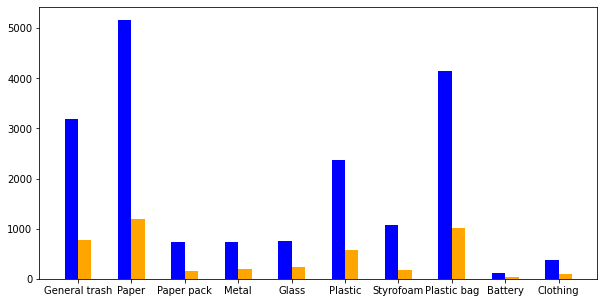

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

imgs = [str(i) for i in range(4883)]                            # 이미지들에 접근하기 위해 형태에 맞게 이미지 번호를 저장한다.
for i in range(len(imgs)):
    while len(imgs[i])<4: imgs[i] = '0'+imgs[i] 


train_txts_path = './train/labels'
valid_txts_path = './valid/labels'

train_images = [0 for _ in range(10)]
valid_images = [0 for _ in range(10)]


for img in imgs:
    txt_path = os.path.join(train_txts_path, img+'.txt')
    if not os.path.exists(txt_path):
        continue
    txt_file = open(txt_path, 'r')
    lines = txt_file.readlines()
    
    for line in lines:
        category, x, y, w, h = line.split()
        train_images[int(category)] += 1
    
    txt_file.close()

for img in imgs:
    txt_path = os.path.join(valid_txts_path, img+'.txt')
    if not os.path.exists(txt_path):
        continue
    txt_file = open(txt_path, 'r')
    lines = txt_file.readlines()
    
    for line in lines:
        category, x, y, w, h = line.split()
        valid_images[int(category)] += 1
    
    txt_file.close()

plt.figure(figsize=(10,5))
index = np.arange(10)
plt.bar(index-0.125, train_images, width=0.25, color='blue')
plt.bar(index+0.125, valid_images, width=0.25, color='orange')
plt.xticks(index, ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing'])
plt.show()


* 학습 명령: <br>
(1) python train.py --img 1024 --batch 8 --epochs 70 --data './data/aug_dataset.yaml' --cfg './models/yolov5x6.yaml' --weights yolov5x6.pt --hyp './runs/evolve/YoloV5x_Hyp_tuning/hyp_evolve.yaml' --label-smoothing 0.1 --name YoloV5x6_Create_Data --cache

* 테스트 명령: <br>
(1) python detect.py --img 1024 --source './data/test' --weights './runs/train/YoloV5x6_Create_Data/weights/best.pt' --save-txt --save-conf --name YoloV5x6_Create_Data --augment

In [12]:
import pandas as pd
import os

df = pd.DataFrame(index=[i for i in range(4871)], columns=['PredictionString', 'image_id'])
yolo_path = './../yolov5/runs/detect/YoloV5x6_Create_Data/labels'
for img_index in range(4871):
    image_id = str(img_index)
    while len(image_id)<4: image_id = '0'+image_id

    PredictionString = ''
    try: 
        txt_file = open(os.path.join(yolo_path, image_id+'.txt'), 'r')
        lines = txt_file.readlines()
    
        for line in lines:
            category, yolo_x, yolo_y, yolo_w, yolo_h, pred = (line.split())
            x_min = (float(yolo_x)-float(yolo_w)/2)*1024
            y_min = (float(yolo_y)-float(yolo_h)/2)*1024
            x_max = x_min+float(yolo_w)*1024
            y_max = y_min+float(yolo_h)*1024
            PredictionString += f'{category} {pred} {x_min} {y_min} {x_max} {y_max} '
        txt_file.close()
    except FileNotFoundError:
        pass
    
    df.iloc[img_index] = [PredictionString, 'test/'+image_id+'.jpg']

df.to_csv('./YoloV5x6__Create_Data.csv', index=False)

<h3> <strong> 2. 결과 </strong> </h3>

기존 0.5587 mAP에서 0.5630 mAP로 약 0.05 정도 성능이 향상되었다.